### Libraries

In [ ]:
# !pip install langchain==0.1.7 --quiet
!pip install langchain==0.1.10 --quiet
!pip install transformers --quiet
!pip install sentence-transformers --quiet
!pip install chromadb --quiet
!pip install pypdf --quiet
!pip install openai --quiet
!pip install langchain-openai --quiet

**Package related issues**
* `langchain > 0.1.7` might give error on `.invoke()` while working with HuggingFace Models
* Shows deprecation warning if `langchain.chat_models import ChatOpenAI` is used.

In [2]:
import os
import langchain
import transformers
import sentence_transformers

from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.document_loaders import TextLoader, PyPDFLoader, PyPDFDirectoryLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma

# from langchain.chat_models import ChatOpenAI
from langchain_openai import ChatOpenAI

from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, AutoModelForQuestionAnswering, AutoConfig, AutoModel, T5Tokenizer, T5ForConditionalGeneration

from google.colab import drive
drive.mount('/content/drive')

print(f"langchain version: {langchain.__version__}")

Mounted at /content/drive
langchain version: 0.1.10


### RAG: Retrieval-Augmented Generation<br>


Basic architecture for question-answering pipeline with external knowledge base. RAG model augments the user input (or prompts) by adding the relevant retrieved data in context. This step uses prompt engineering techniques to communicate effectively with the LLM. The augmented prompt allows the large language models to generate an accurate answer to user queries.


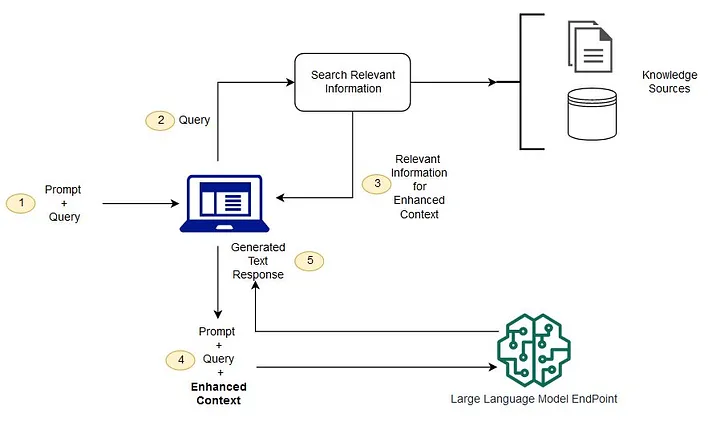

#### Exploration of langchain and it's components to generate answer for questions with context
* Document loaders, splitting and chunking
* Basic vector database and sementic similarity search with embeddings
* Integration with Huggingface embeddings, llm models, pipelines and inference
* Integration with OPENAI API llm model inference


In [3]:
doc_directory = '/content/drive/MyDrive/Work/document_question_answering/docs/'

# Use the following line for loading .txt/.md files
# loader = TextLoader(doc_directory+"sample_input2.pdf")

# Use the following lines for loading .pdf files
# loader = PyPDFLoader(doc_directory+"sample_school_rules_regulations.pdf")
# docs = loader.load_and_split()
loader = PyPDFDirectoryLoader(doc_directory)
docs = loader.load() # will auto split into pages
print(f"Total Pages: {len(docs)}")

Total Pages: 21


In [4]:
texts = docs

# The following is for .txt files
# text_splitter = CharacterTextSplitter(chunk_size=100, chunk_overlap=0)
# texts = text_splitter.split_documents(docs)

### Embeddings & vector storage

We can use different model for document vector storage and retrieval as the model being used for text generation might be missing sentence-transformer embeddings.

In [ ]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
hf_embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

In [6]:
to_embed_texts = []
for i in range(len(texts)):
    to_embed_texts.append(texts[i].page_content)

embedded_texts = hf_embeddings.embed_documents(to_embed_texts)
print(len(embedded_texts), len(embedded_texts[0]))

doc_vector_db = Chroma.from_documents(texts, hf_embeddings)


21 768


### Model & pipeline definition

#### Huggingface pipeline

In [ ]:
# Specify the model name from hugging face models/
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0" # other model(s) that worked: ["google/flan-t5-large"]

# Load the tokenizer associated with the specified model
# tokenizer = T5Tokenizer.from_pretrained(model_name, truncation=True, load_in_8_bit=False, device_map="auto")

# Load the model
# model = T5ForConditionalGeneration.from_pretrained(model_id)

# Create a pipeline instance from HugginFace
# hf_pipe = pipeline(model=model,tokenizer=tokenizer,task='text-generation',max_length=512,repetition_penalty=1.1)
hf_pipe = pipeline("text-generation", model=model_name) # parameters for gpu usage device_map="auto"

# Create an instance of the HuggingFacePipeline, wrapping a huggingface pipeline with additional model-specific arguments
llm_pipeline = HuggingFacePipeline(pipeline=hf_pipe, model_kwargs={"temperature": 0.4, "max_length": 512})

#### OpenAI API pipeline

**OpenAI offers free trial for it's apis with credit of $5.** Each trial is tied to an account's phone number and available for 3 months since creation.

In [8]:
os.environ["OPENAI_API_KEY"] = "OPENAI-API-KEY"
model_name = "gpt-3.5-turbo"
openai_llm_pipeline = ChatOpenAI(model_name=model_name)

### Chat Templates

#### HuggingFace pipeline
Chat templates can be a bit tricky when trying to use with HuggingFace pipeline.<br>
`pipeline.tokenizer.apply_chat_template` returns a `str` created by concatanating the whole dictionary. This `str` then can be passed to langchain's `PromptTemplate.from_template()`. <br>
Otherwise this can lead to this issue: https://github.com/langchain-ai/langchain/issues/15884

In [18]:
# Use the tokenizer's chat template to format each message - see https://huggingface.co/docs/transformers/main/en/chat_templating
hf_message_template = [
    {
        "role": "system",
        "content": "You are a friendly chatbot, answer. Use the following context if it's available but don't quote from source, phrase in your own words, If you do not know, answer that you don't have knowledge on that. Here is the context: {context}",
    },
    {"role": "user", "content": "{question}"},
]
message_template = hf_pipe.tokenizer.apply_chat_template(hf_message_template, tokenize=False, add_generation_prompt=True)


#### OpenAI API Pipeline

In [10]:
message_template ="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Be as verbose and educational in your response as possible.
    context: {context}
    Question: "{question}"
    Answer:
    """

### Query embedding and context retrieval

Before running model to get response, we first need to retrieve chunk from document by searching for similarity with the query. Query also need to be embedded.

In [ ]:
question = "Can I bring a phone to school ? Are there any restrictions ?"
# question = "What will happen if I misbehave during class ?"
# question = "What if a student is late ? By what time a student should be in class ? be specific."
# question = "Who is the first president of the usa ?"

question_vector = hf_embeddings.embed_query(question)
# print(len(query_vector))


similar_docs = doc_vector_db.similarity_search_by_vector(question_vector, k=1)
# similar_docs

context = similar_docs[0].page_content

# Check which page(s) are returned in similarity search
for split_page in similar_docs:
    print(split_page.metadata)

In [17]:
print(context)

 
of openin g and regulations for which  are posted.   All unmarked  and unclaimed  article s will 
be disposed of at the end of each term.  The loss or discover y of any money  or valuable s 
is to be reporte d to the Assistan t Head or to a Head of Year or, if they are not available,  to 
a member  of staff.  Valuables found lying abou t are to be handed  in to the School  Office 
for safe keeping.  Th e borrowing  of any propert y is forbidden,  unles s the owner  has given 
his prior permission.  All student s are expected to co-operat e in the prevention of theft, not 
least by safeguarding  their own belongings .  Items of significan t value or large  cash  
amounts shoul d not be brought to sc hool. It is recommended that expensive phones, 
laptops or other items should not be brought to school unless it is necessary. It is essential 
that expensive items are looked after by the individual and in particular are not left in bags around the school.  
 Durin g P.E.,  Games , Hous e

### Inference

#### With HuggingFace pipeline

The following is for directly getting output from a HuggingFace model. **langchain is not involved here**.

In [ ]:
# Replace placeholders with actual values
prompt = message_template.replace("{context}", context).replace("{question}", question)

outputs = hf_pipe(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
print(outputs[0]["generated_text"])

#### Through langchain pipeline

`PromptTemplate.from_template` expects `str`. So, for HuggingFace Pipeline,
1. First apply `pipeline.tokenizer.apply_chat_template` on message template. It returns a `str`
2. Then create a template from this `str` with lanchain's promptTemplate.
3. **Necessary for `TinyLlama/TinyLlama-1.1B-Chat-v1.0` model**. Other models may differ.

In [13]:
prompt = PromptTemplate.from_template(message_template)
print(prompt.input_variables)

['context', 'question']


In [14]:
# this run is for HuggingFace pipelines
query_llm = LLMChain(llm=llm_pipeline, prompt=prompt)
response = query_llm.invoke({"context":context, "question": question})
print(response["text"])

 Yes, you can bring a phone to school, but it should be treated with the utmost respect. Mobile phones should not be out on school premises unless permission is given by a member of staff. Mobile phones should not be used under tightly controlled conditions, and they should not be out on school premises unless permission is given by a member of staff. Mobile phones should not be used for any purpose other than calling home or recording homework. Mobile phones should not be brought into school, and parents or guardians should consider adding mobile phones to their house insurance in case of loss. Mobile phones should not be used for any purpose other than calling home or recording homework.


In [16]:
# this run is for openai api
query_llm = LLMChain(llm=openai_llm_pipeline, prompt=prompt)
response = query_llm.invoke({"context":context, "question": question})
print(response["text"])

Yes, you can bring a phone to school at Whitgift School, but there are specific restrictions and guidelines in place. According to the Mobile Devices policy, the carrying of mobile phones is permitted, but they may only be used under tightly controlled conditions. Specifically, mobile phones should not be out on school premises unless permission is given by a member of staff, such as to ring home or to record homework. 

It is important to note that mobile phones are brought to Whitgift entirely at the owner's risk, and the school does not accept responsibility for them. Parents or guardians are advised to consider adding mobile phones to their house insurance in case of loss. Additionally, it is recommended that expensive phones should not be brought into school to avoid any potential risks.

Furthermore, misuse of mobile phones, such as sending offensive voicemails, text messages, or images, constitutes bullying and will lead to disciplinary sanctions. Parents or guardians should be 